# baseline fft report

**prep data**
1. filter only 'Sleep stage W', 'Sleep stage 4' labels
2. train valid split by person
3. min max scale EEG data
4. fourier transform on raw EEG data
5. statistics in delta, theta and alpha spectrum bands as features
6. train LBGMClassifier

**metrics**

|label |precision  | recall|
--- | --- | ---|
|sleep stage 4|0.8621|0.9215|
|sleep stage W|0.9542|0.5170|


In [2]:
from IPython.core.debugger import set_trace
from lightgbm import LGBMClassifier, early_stopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, roc_auc_score, PrecisionRecallDisplay
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq, fftshift
from tqdm.notebook import tqdm

# load data

In [3]:
train_data = np.load('../data/raw/train_samples.win500.npy', allow_pickle=True)
test_data = np.load('../data/raw/two_stage_test.npy', allow_pickle=True)

In [4]:
train_data.shape, test_data.shape

((324552,), (15696,))

In [5]:
df_train = pd.DataFrame(list(train_data))
df_test = pd.DataFrame(list(test_data))

In [6]:
df_train.head()

,label,time,value,person
0,Sleep stage W,0,"[[-72.44151404151403, 1.0683760683760717], [-7...",SC4022
1,Sleep stage W,5,"[[-8.093772893772893, 2.3504273504273536], [-1...",SC4022
2,Sleep stage W,10,"[[62.52039072039072, 7.136752136752141], [70.4...",SC4022
3,Sleep stage W,15,"[[-3.2302808302808286, 1.2393162393162427], [-...",SC4022
4,Sleep stage W,20,"[[-12.770207570207567, -12.094017094017088], [...",SC4022


In [8]:
type(df_train['value'][0][0][0])

numpy.float64

In [9]:
df_train_ch = df_train[df_train['label'].isin(['Sleep stage W', 'Sleep stage 4'])]

In [10]:
df_train_ch.shape

(234996, 4)

# prep data

In [11]:
train_persons, valid_persons = train_test_split(df_train['person'].unique(), test_size=0.1)

In [12]:
ss4_count = df_train[df_train['person'].isin(list(train_persons)) & (df_train['label'] == 'Sleep stage 4')].shape[0]

In [13]:
ssw_count = df_train[df_train['person'].isin(list(train_persons)) & (df_train['label'] == 'Sleep stage W')].shape[0]

In [14]:
ss4_count / (ss4_count + ssw_count)

0.011462849676308132

In [15]:
ss4_valid_count = df_train[df_train['person'].isin(list(valid_persons)) & (df_train['label'] == 'Sleep stage 4')].shape[0]

In [16]:
ssw_valid_count = df_train[df_train['person'].isin(list(valid_persons)) & (df_train['label'] == 'Sleep stage W')].shape[0]

In [17]:
ss4_valid_count / (ss4_valid_count + ssw_valid_count)

0.03423160961398398

In [18]:
def fft_feature_gen(i, j, signal):
    feature_list = []
    
    N = signal.shape[0]    
    signal_ft_ = fft(signal)
    signal_ft_ = 2.0 / N * np.abs(signal_ft_[0: N // 2])
    
    signal_ft_min = signal_ft_.min()
    signal_ft_max = signal_ft_.max()
    
    signal_ft = (signal_ft_ - signal_ft_min) / (signal_ft_max - signal_ft_min)

    signal_ft_mean = signal_ft[i:j].mean()
    signal_ft_max = signal_ft[i:j].max()
    signal_ft_min = signal_ft[i:j].min()
    signal_ft_std = signal_ft[i:j].std()
    signal_ft_median = np.quantile(signal_ft[i:j], q=.5)
    signal_ft_q95 = np.quantile(signal_ft[i:j], q=.95)
    signal_ft_q5 = np.quantile(signal_ft[i:j], q=.05)

    feature_list.extend([
        signal_ft_mean, signal_ft_max, signal_ft_min, signal_ft_std, 
        signal_ft_median, signal_ft_q95, signal_ft_q5
    ])
    
    return feature_list


def feature_gen(fpz, pz):
    sp_boundary_list = [0, 20, 40, 70]
    feature_list = []
    
    for i in range(len(sp_boundary_list) - 1):
        feature_list.extend(
            fft_feature_gen(sp_boundary_list[i], sp_boundary_list[i + 1], fpz)
        )
        feature_list.extend(
            fft_feature_gen(sp_boundary_list[i], sp_boundary_list[i + 1], pz)
        )
    return feature_list

In [19]:
def min_max_scaler(y):
    y_ = y.T
    y_min = y_.min(axis=1).reshape(-1, 1)
    y_max = y_.max(axis=1).reshape(-1, 1)
    res = (y_ - y_min) / (y_max - y_min)
    return res.T

In [20]:
def train_valid_prep(data, train_person_list=None, valid_preson_list=None):
    train_feature_list = []
    train_target_list = []
    valid_feature_list = []
    valid_target_list = []
    
    for row in tqdm(data):
        row['value'] = row['value'].astype(np.float32)
        if row['label'] == 'Sleep stage 4':
            target = 1
        elif row['label'] == 'Sleep stage W':
            target = 0
        else:
            continue
            
        fpz = row['value'][:, 0]
        pz = row['value'][:, 1]
        
        if  train_person_list is None or row['person'] in train_person_list:
            train_feature_list.append(feature_gen(fpz, pz))
            train_target_list.append(target)


        elif row['person'] in valid_preson_list:
            valid_feature_list.append(feature_gen(fpz, pz))
            valid_target_list.append(target)

        
    return np.array(train_feature_list), np.array(train_target_list), np.array(valid_feature_list), np.array(valid_target_list)

In [21]:
X_train, y_train, X_valid, y_valid = train_valid_prep(train_data, train_persons, valid_persons)
X_test, y_test, _, _ = train_valid_prep(test_data)

In [22]:
X_train[52872], X_test[0]

(array([0.43353376, 1.        , 0.04641768, 0.2664592 , 0.43935563,
        0.85979235, 0.09340868, 0.50010765, 1.        , 0.08781661,
        0.253104  , 0.41102758, 0.85082921, 0.15966201, 0.09336535,
        0.23508602, 0.01448709, 0.05861111, 0.07277104, 0.19693988,
        0.02919558, 0.27923223, 0.93316823, 0.02227282, 0.20957389,
        0.23412143, 0.51061164, 0.03554995, 0.04513692, 0.10349202,
        0.00463566, 0.02559309, 0.03562332, 0.09669267, 0.01464339,
        0.18584672, 0.41042295, 0.00629018, 0.1066797 , 0.17391735,
        0.35083907, 0.03312618]),
 array([5.00000007e-02, 1.00000000e+00, 0.00000000e+00, 2.17944935e-01,
        8.28408675e-10, 5.00000069e-02, 0.00000000e+00, 5.00000007e-02,
        1.00000000e+00, 0.00000000e+00, 2.17944935e-01, 0.00000000e+00,
        5.00000058e-02, 0.00000000e+00, 2.84337304e-10, 1.66552561e-09,
        0.00000000e+00, 4.03273970e-10, 0.00000000e+00, 7.09512352e-10,
        0.00000000e+00, 1.14258558e-09, 1.94467518e-08, 0.0000

In [21]:
y_train.mean(), y_valid.mean(), y_test.mean()

(0.007833991149384045, 0.05452638937434463, 0.5229357798165137)

# train model

In [23]:
model = LGBMClassifier(
    n_estimators=1_000,
    random_state=0,
)

In [24]:
model.fit(
    X=X_train,
    y=y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric='roc_auc',
    callbacks=[early_stopping(5)]
)

[1]	valid_0's binary_logloss: 0.174175
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.17133
[3]	valid_0's binary_logloss: 0.155704
[4]	valid_0's binary_logloss: 0.150113
[5]	valid_0's binary_logloss: 0.148566
[6]	valid_0's binary_logloss: 0.148008
[7]	valid_0's binary_logloss: 0.148175
[8]	valid_0's binary_logloss: 0.147472
[9]	valid_0's binary_logloss: 0.137996
[10]	valid_0's binary_logloss: 0.136877
[11]	valid_0's binary_logloss: 0.136876
[12]	valid_0's binary_logloss: 0.135384
[13]	valid_0's binary_logloss: 0.133447
[14]	valid_0's binary_logloss: 0.133
[15]	valid_0's binary_logloss: 0.132594
[16]	valid_0's binary_logloss: 0.132493
[17]	valid_0's binary_logloss: 0.132086
[18]	valid_0's binary_logloss: 0.131744
[19]	valid_0's binary_logloss: 0.131027
[20]	valid_0's binary_logloss: 0.130553
[21]	valid_0's binary_logloss: 0.130439
[22]	valid_0's binary_logloss: 0.130203
[23]	valid_0's binary_logloss: 0.129629
[24]	valid_0's binary_logloss: 0.

LGBMClassifier(n_estimators=1000, random_state=0)

# metrics

In [39]:
train_roc_auc_score = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])
valid_roc_auc_score = roc_auc_score(y_valid, model.predict_proba(X_valid)[:, 1])
test_roc_auc_score = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

In [40]:
train_roc_auc_score, valid_roc_auc_score, test_roc_auc_score

(0.9955997029951092, 0.9794658020917263, 0.9456537298534055)

## precision-recall on Sleep stage 4

In [41]:
X_test[0]

array([5.00000007e-02, 1.00000000e+00, 0.00000000e+00, 2.17944935e-01,
       8.28408675e-10, 5.00000069e-02, 0.00000000e+00, 5.00000007e-02,
       1.00000000e+00, 0.00000000e+00, 2.17944935e-01, 0.00000000e+00,
       5.00000058e-02, 0.00000000e+00, 2.84337304e-10, 1.66552561e-09,
       0.00000000e+00, 4.03273970e-10, 0.00000000e+00, 7.09512352e-10,
       0.00000000e+00, 1.14258558e-09, 1.94467518e-08, 0.00000000e+00,
       4.20457269e-09, 0.00000000e+00, 1.50260163e-09, 0.00000000e+00,
       5.35536948e-10, 9.40590716e-09, 0.00000000e+00, 1.68067427e-09,
       2.20735034e-10, 1.24765251e-09, 0.00000000e+00, 3.58551855e-10,
       7.96443178e-09, 0.00000000e+00, 1.41704393e-09, 0.00000000e+00,
       2.91843497e-10, 0.00000000e+00])

In [42]:
precision, recall, _ = precision_recall_curve(y_test, model.predict_proba(X_test)[:, 1])

In [43]:
ind = np.where(recall >= 0.92153996)[0].max()

In [44]:
precision[ind], recall[ind]

(0.8620925461591065, 0.9215399610136452)

In [45]:
prc = PrecisionRecallDisplay(precision, recall)

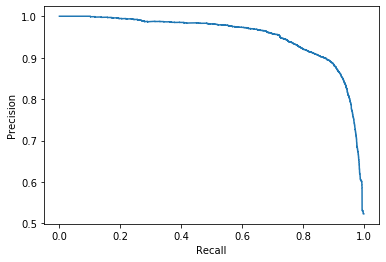

In [46]:
prc.plot()

## precision-recall on Sleep stage W

In [47]:
y_test_0 = np.ones(len(y_test)) - np.array(y_test)

In [48]:
precision, recall, _ = precision_recall_curve(
    y_test_0,
    model.predict_proba(X_test)[:, 0]
)

In [49]:
ind = np.where(recall >= 0.51696047)[0].max()

In [50]:
precision[ind], recall[ind]

(0.9541533152575795, 0.5169604700854701)

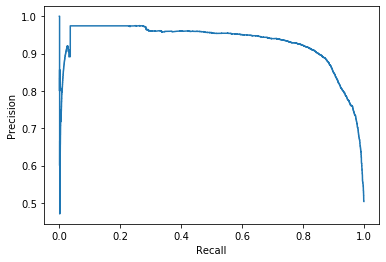

In [51]:
prc = PrecisionRecallDisplay(precision, recall)
prc.plot()